# Загрузка данных

Импорт и установка библиотек

In [1]:
!pip install pmdarima
!pip install numpy==1.26.4
!pip install keras-tuner


from pmdarima import auto_arima
import warnings
import requests
import statsmodels
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from io import BytesIO
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.stattools import acf, adfuller
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow.keras.layers import LSTM, Dense, Dropout
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA



warnings.filterwarnings("ignore")
%matplotlib inline

Выберите способ загрузки данных

In [2]:
url = "https://github.com/samoletpanfilov/reinforcement_task/raw/refs/heads/master/data/train.xlsx"  # Ссылка должна содержать raw
response = requests.get(url)
df_ts = pd.read_excel(BytesIO(response.content), engine='openpyxl')

df_ts = df_ts.sort_values(by='dt', ascending=True)

In [3]:
# df_ts = pd.read_excel('/content/drive/MyDrive/int/train.xlsx')

# Анализ и предобработка

### просмотр статистической информации

In [4]:
df_ts.head(15)

,dt,Цена на арматуру
0,2015-01-05,32900
1,2015-01-12,32500
2,2015-01-19,32000
3,2015-01-26,30700
4,2015-02-02,30300
5,2015-02-09,30300
6,2015-02-16,30100
7,2015-02-23,29400
8,2015-03-02,29200
9,2015-03-09,29000


In [5]:
df_ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   dt                400 non-null    datetime64[ns]
 1   Цена на арматуру  400 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 6.4 KB


In [6]:
# Проверка на наличие NaN
df_ts['dt'].isna().sum()

0

In [7]:
df_ts.describe()

,dt,Цена на арматуру
count,400,400.000000
mean,2018-11-01 12:00:00,39229.475000
min,2015-01-05 00:00:00,21000.000000
25%,2016-12-03 06:00:00,31075.000000
50%,2018-11-01 12:00:00,35450.000000
75%,2020-09-29 18:00:00,42000.000000
max,2022-08-29 00:00:00,79000.000000
std,NaN,13407.979668


In [8]:
df_ts.shape

(400, 2)

### Визуализация

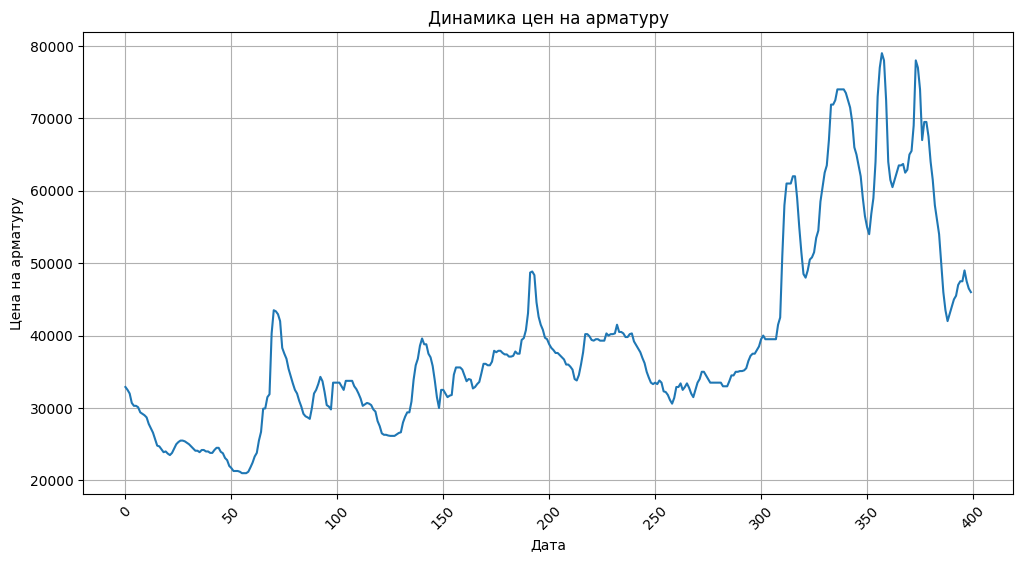

In [9]:
# Строим график
plt.figure(figsize=(12, 6))
plt.plot(df_ts["Цена на арматуру"], marker='', linestyle='-')

# Настроим оси и заголовок
plt.xlabel("Дата")
plt.ylabel("Цена на арматуру")
plt.title("Динамика цен на арматуру")
plt.grid(True)

# Улучшим читаемость меток дат
plt.xticks(rotation=45)

# Показываем график
plt.show()

**Вопросы к графику:**

 1.Есть ли тренд?

 2.Есть ли сезонность?

 3.Насколько сильный шум?



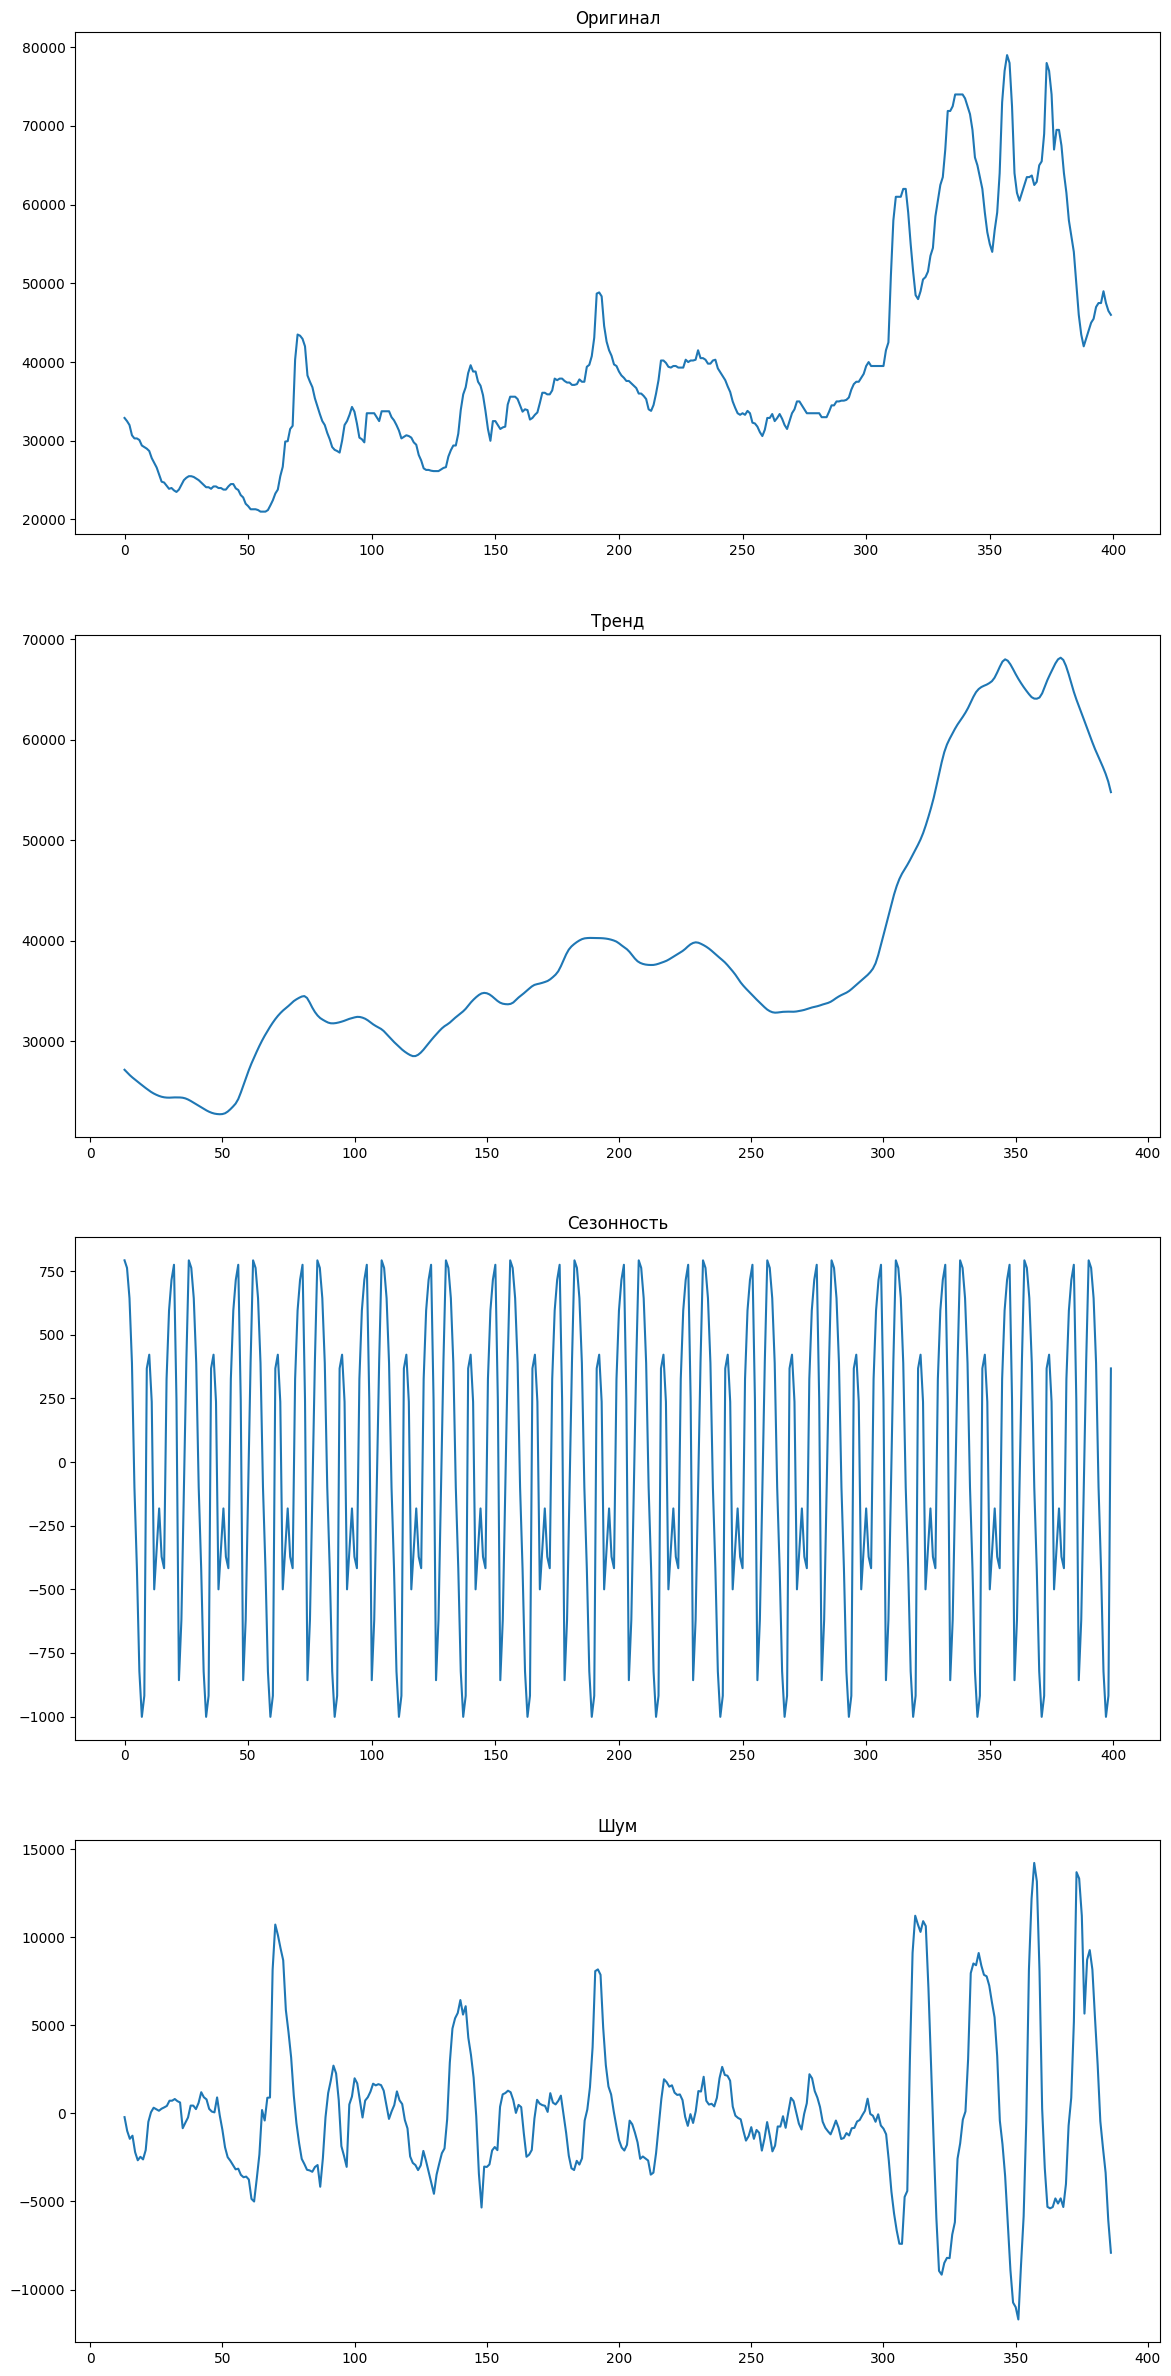

In [10]:
# Разложим ряд на компоненты и проверим ответы на вопросы

fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(14, 30))
decompose = seasonal_decompose(df_ts['Цена на арматуру'],period = 26)

ax[0].set_title('Оригинал')
ax[1].set_title('Тренд')
ax[2].set_title('Сезонность')
ax[3].set_title('Шум')

decompose.observed.plot(ax=ax[0])
decompose.trend.plot(ax=ax[1])
decompose.seasonal.plot(ax=ax[2])
decompose.resid.plot(ax=ax[3]);

Декомпозиция временного ряда


🔹 Оригинальный ряд  


Исходные данные, содержащие тренд, сезонность и шум.


 📈 Тренд

   
Общий восходящий тренд, отражающий долгосрочный рост.


🔄 Сезонность


Выраженные периодические колебания, сохраняющиеся на протяжении всего ряда.


 🔀 Шум  

Умеренный, но увеличивается ближе к концу ряда, что может указывать на аномалии или возрастание волатильности.


### Работа с автокорреляцией

In [11]:
# Получил 'сырые' значения автокорреляций
acf(df_ts["Цена на арматуру"] ,nlags = 100, fft = False)

array([1.        , 0.99138242, 0.97367714, 0.95122039, 0.92740427,
       0.90357365, 0.88126621, 0.8606089 , 0.84235253, 0.82671727,
       0.81349611, 0.8020525 , 0.7925797 , 0.78508849, 0.78019657,
       0.77692922, 0.77376814, 0.76901294, 0.76227632, 0.75319077,
       0.74261145, 0.7309889 , 0.71862345, 0.7046383 , 0.68939965,
       0.67325908, 0.65612584, 0.63820561, 0.62109396, 0.60459259,
       0.58872289, 0.57435372, 0.56120831, 0.54900152, 0.5377084 ,
       0.5271632 , 0.51674918, 0.5068141 , 0.49691253, 0.48636205,
       0.47460061, 0.4600824 , 0.44257206, 0.42285538, 0.40223733,
       0.38033844, 0.35769402, 0.33517203, 0.31316745, 0.29306128,
       0.27522925, 0.2595102 , 0.24447201, 0.23086215, 0.21896621,
       0.20859445, 0.1993889 , 0.19088593, 0.18300826, 0.1757314 ,
       0.16880023, 0.16166525, 0.15350675, 0.14370082, 0.13267574,
       0.12198755, 0.11231837, 0.10288107, 0.0929827 , 0.08286002,
       0.07336018, 0.06476539, 0.05709237, 0.05068118, 0.04473

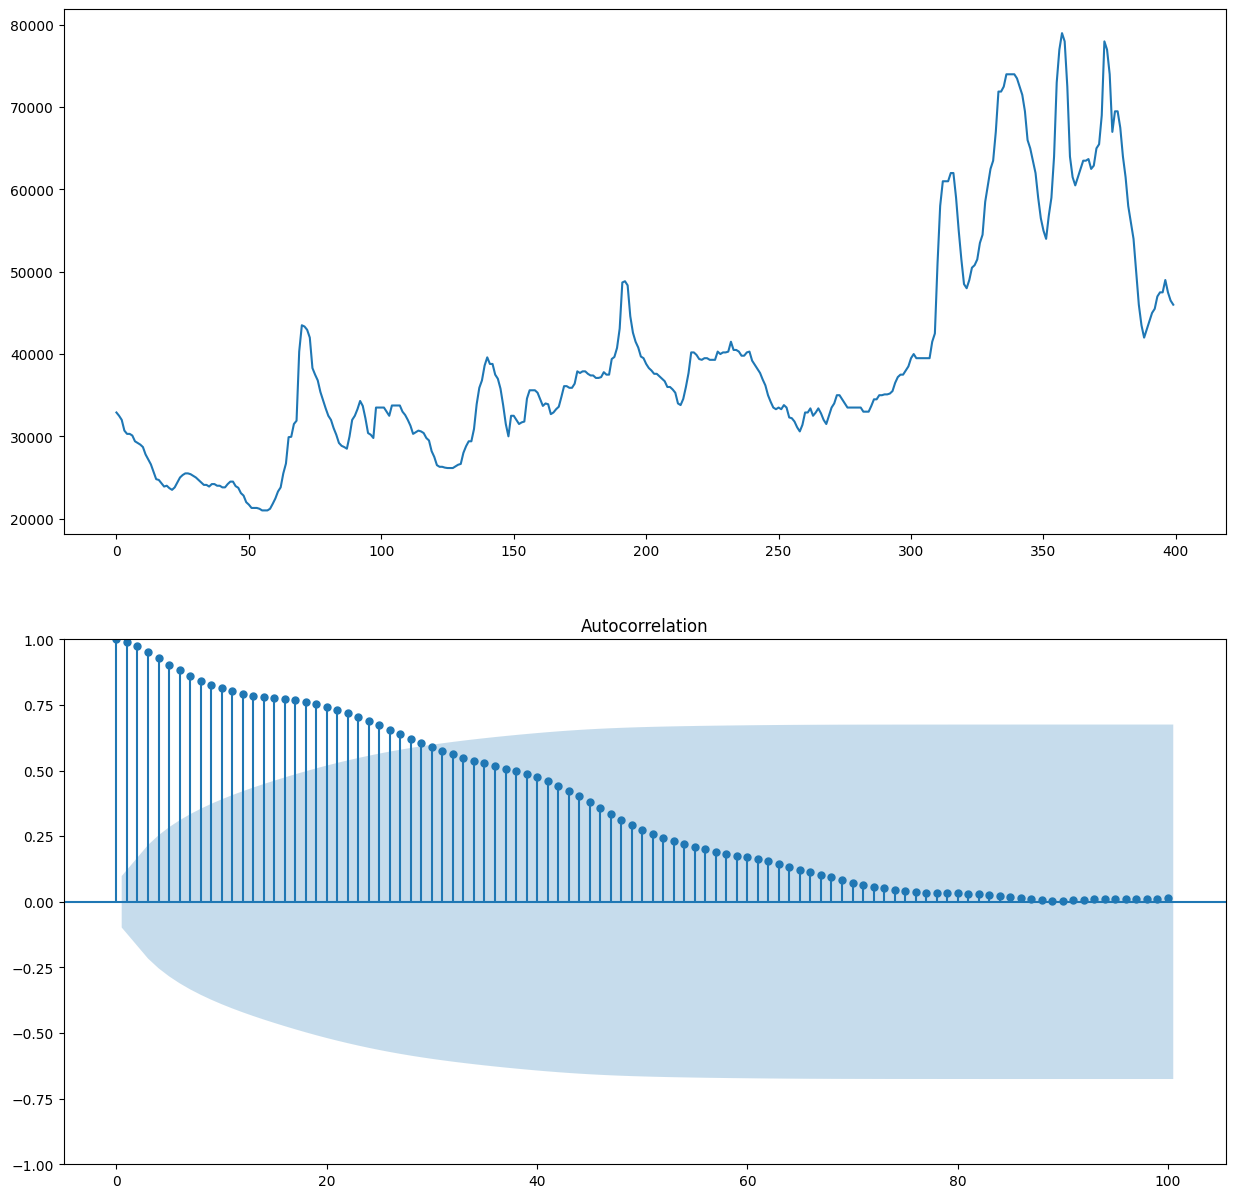

In [12]:
# Визуализация автокорреляции
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))
df_ts['Цена на арматуру'].plot(ax=ax[0])
plot_acf(df_ts['Цена на арматуру'], lags=100, ax=ax[1]);

Высокая корреляция на малых лагах указывает на сильную зависимость текущих значений от предыдущих.

Корреляция постепенно уменьшается с увеличением лага, что характерно для многих временных рядов.


Светло-синяя область – это доверительный интервал: значения внутри него можно считать статистически незначимыми.

In [13]:
# проверка на стационарность первоначального ряда
# Функция для выполнения теста ADF
def adf_test(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print(f"Critical Values: {result[4]}")

    if result[1] < 0.05:
        print("Ряд стационарен (p-value < 0.05)")
    else:
        print("Ряд нестационарен (p-value >= 0.05)")
# Проверим на стационарность исходный ряд
adf_test(df_ts['Цена на арматуру'])

ADF Statistic: -1.9258699893713456
p-value: 0.31999061025699155
Critical Values: {'1%': -3.4470566389664703, '5%': -2.8689037160476016, '10%': -2.570692663557422}
Ряд нестационарен (p-value >= 0.05)


Text(0.5, 1.0, 'Распределение цен на арматуру')

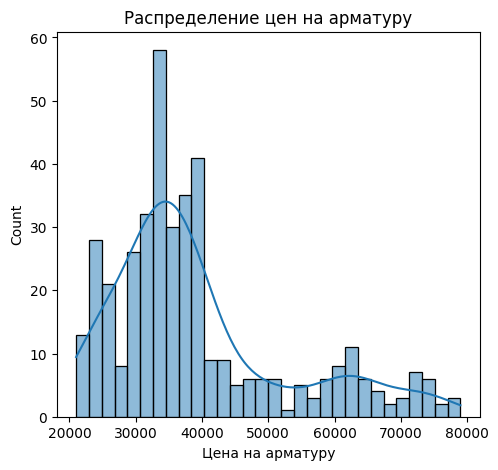

In [14]:
plt.figure(figsize=(12, 5))

# Гистограмма
plt.subplot(1, 2, 1)
sns.histplot(df_ts["Цена на арматуру"], bins=30, kde=True)
plt.title("Распределение цен на арматуру")


На графики видем что большинство значений  примерно сосредоточено между 30тыс и 40тыс

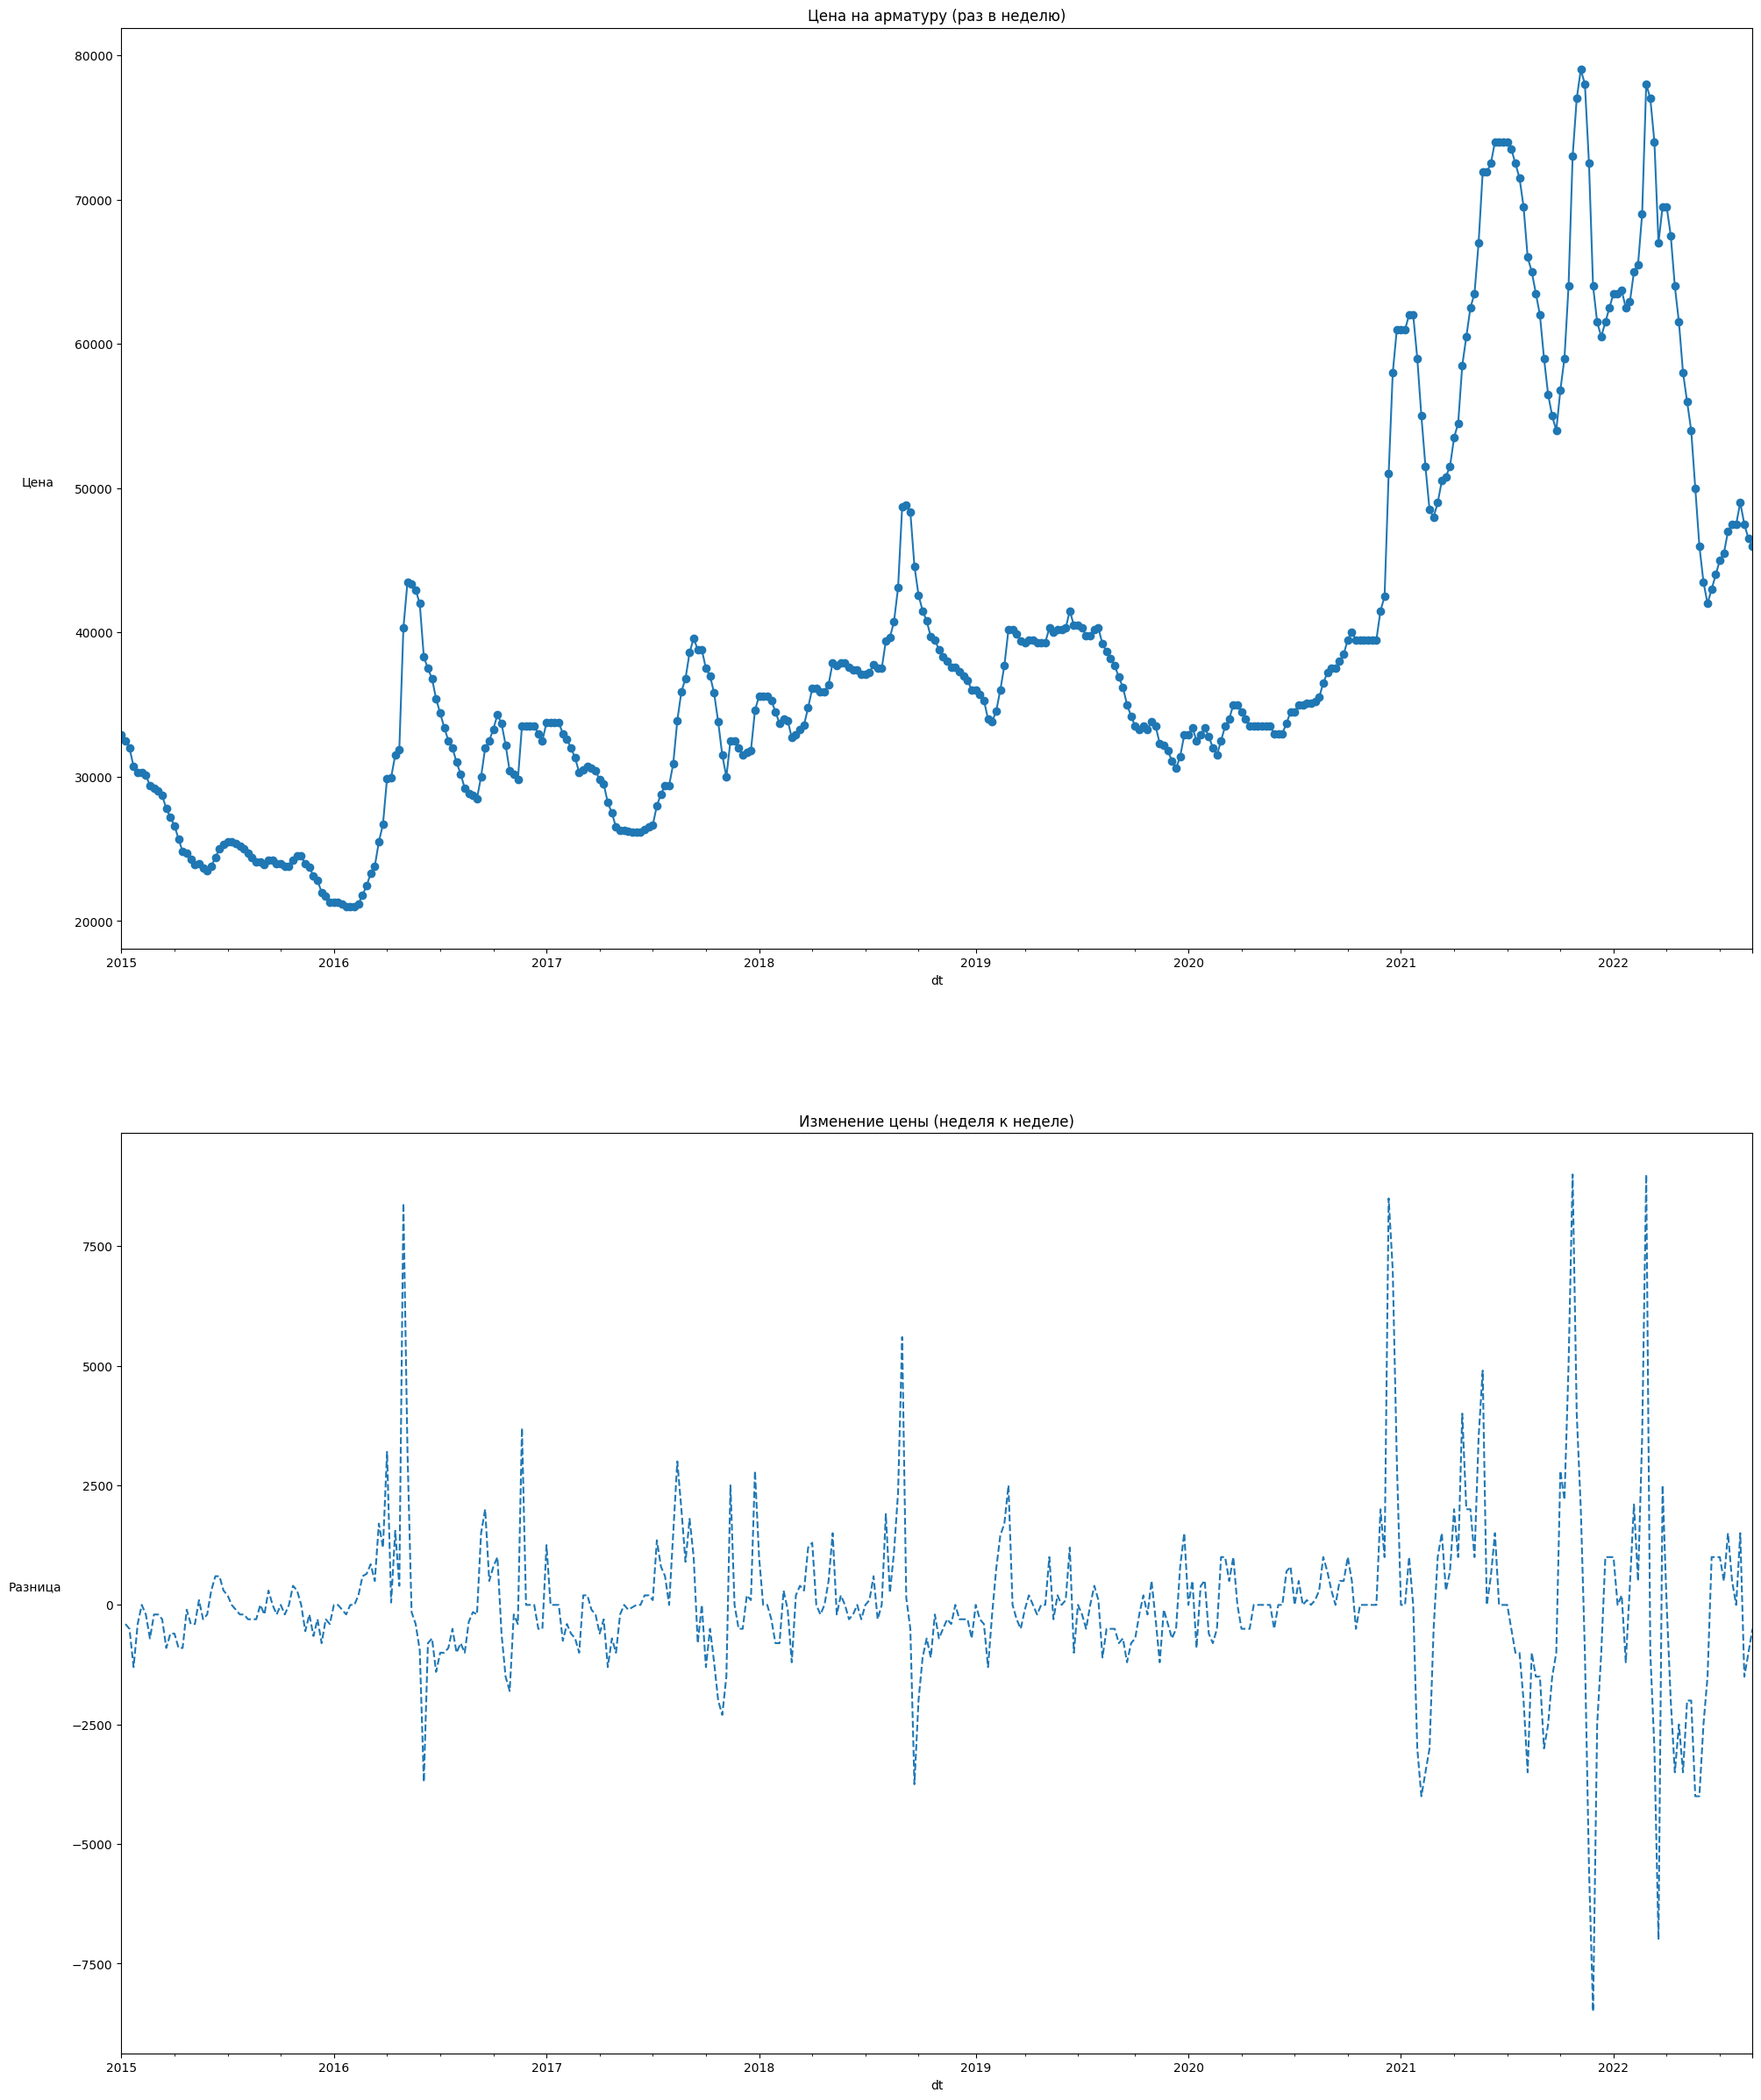

In [15]:
df_ts['Цена_разница_неделя'] = df_ts['Цена на арматуру'].diff(1)  # Разница с прошлой неделей

plt.figure(figsize=(24, 30))

ax1 = plt.subplot(211)
ax1.set_title('Цена на арматуру (раз в неделю)')
ax1.set_ylabel('Цена', rotation=0, labelpad=30)
df_ts.set_index('dt')['Цена на арматуру'].plot(ax=ax1, marker='o')

ax2 = plt.subplot(212)
ax2.set_title('Изменение цены (неделя к неделе)')
ax2.set_ylabel('Разница', rotation=0, labelpad=30)
df_ts.set_index('dt')['Цена_разница_неделя'].plot(ax=ax2, marker='', linestyle='dashed')

plt.show()


1. Верхний график – временной ряд цен на аренду.

Видно наличие тренда: долгосрочный рост цен с колебаниями.

Наблюдаются всплески и падения, возможно, сезонные или вызванные внешними факторами.

В последние годы цены достигли пиковых значений, а затем начали снижаться.
___


2. Нижний график – изменения цен (разность цен между соседними точками).

Колебания вокруг нуля указывают на стационарность изменений.

Присутствуют резкие всплески, что говорит о периодах высокой волатильности.

Возможно, есть влияние новостей, кризисов или других внешних событий.



In [16]:
df_ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   dt                   400 non-null    datetime64[ns]
 1   Цена на арматуру     400 non-null    int64         
 2   Цена_разница_неделя  399 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 9.5 KB


In [17]:
df_ts.replace(np.nan, 0, inplace=True)

In [18]:
df_ts.head(10)

,dt,Цена на арматуру,Цена_разница_неделя
0,2015-01-05,32900,0.0
1,2015-01-12,32500,-400.0
2,2015-01-19,32000,-500.0
3,2015-01-26,30700,-1300.0
4,2015-02-02,30300,-400.0
5,2015-02-09,30300,0.0
6,2015-02-16,30100,-200.0
7,2015-02-23,29400,-700.0
8,2015-03-02,29200,-200.0
9,2015-03-09,29000,-200.0


In [19]:
# проверка на стационарность diff ряда
# Функция для выполнения теста ADF
def adf_test(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print(f"Critical Values: {result[4]}")

    if result[1] < 0.05:
        print("Ряд стационарен (p-value < 0.05)")
    else:
        print("Ряд нестационарен (p-value >= 0.05)")
# Проверим на стационарность исходный ряд
adf_test(df_ts['Цена_разница_неделя'])

ADF Statistic: -7.711973437154185
p-value: 1.2568518586885597e-11
Critical Values: {'1%': -3.447360865754795, '5%': -2.8690374364690445, '10%': -2.5707639493486636}
Ряд стационарен (p-value < 0.05)


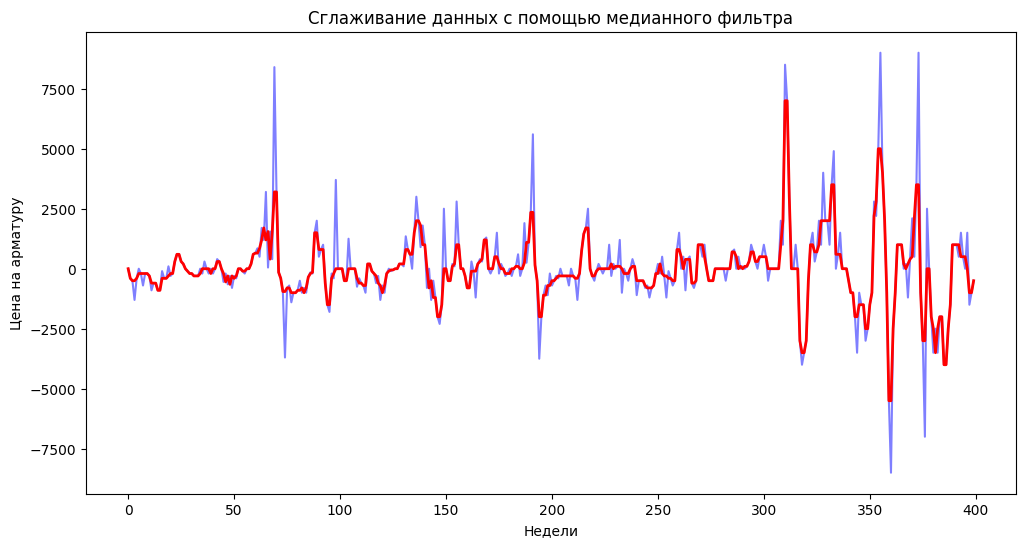

In [20]:
from scipy.signal import medfilt

# Применение медианного фильтра
df_ts["Цена_разница_неделя (сглаженная)"] = medfilt(df_ts["Цена_разница_неделя"], kernel_size=3)

# Построение графика
plt.figure(figsize=(12, 6))

# Исходные данные
plt.plot(df_ts.index, df_ts["Цена_разница_неделя"], label="Исходные данные", color='blue', alpha=0.5)

# Сглаженные данные
plt.plot(df_ts.index, df_ts["Цена_разница_неделя (сглаженная)"], label="Сглаженные данные", color='red', linewidth=2)

# Настройка графика
plt.title("Сглаживание данных с помощью медианного фильтра")
plt.xlabel("Недели")
plt.ylabel("Цена на арматуру")
plt.show()

In [21]:
# проверка на стационарность diff ряда после сглаживания
# Функция для выполнения теста ADF
def adf_test(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print(f"Critical Values: {result[4]}")

    if result[1] < 0.05:
        print("Ряд стационарен (p-value < 0.05)")
    else:
        print("Ряд нестационарен (p-value >= 0.05)")
# Проверим на стационарность исходный ряд
adf_test(df_ts['Цена_разница_неделя (сглаженная)'])

ADF Statistic: -8.108679715553967
p-value: 1.2427490594539653e-12
Critical Values: {'1%': -3.447099431978147, '5%': -2.8689225261604263, '10%': -2.57070269105012}
Ряд стационарен (p-value < 0.05)


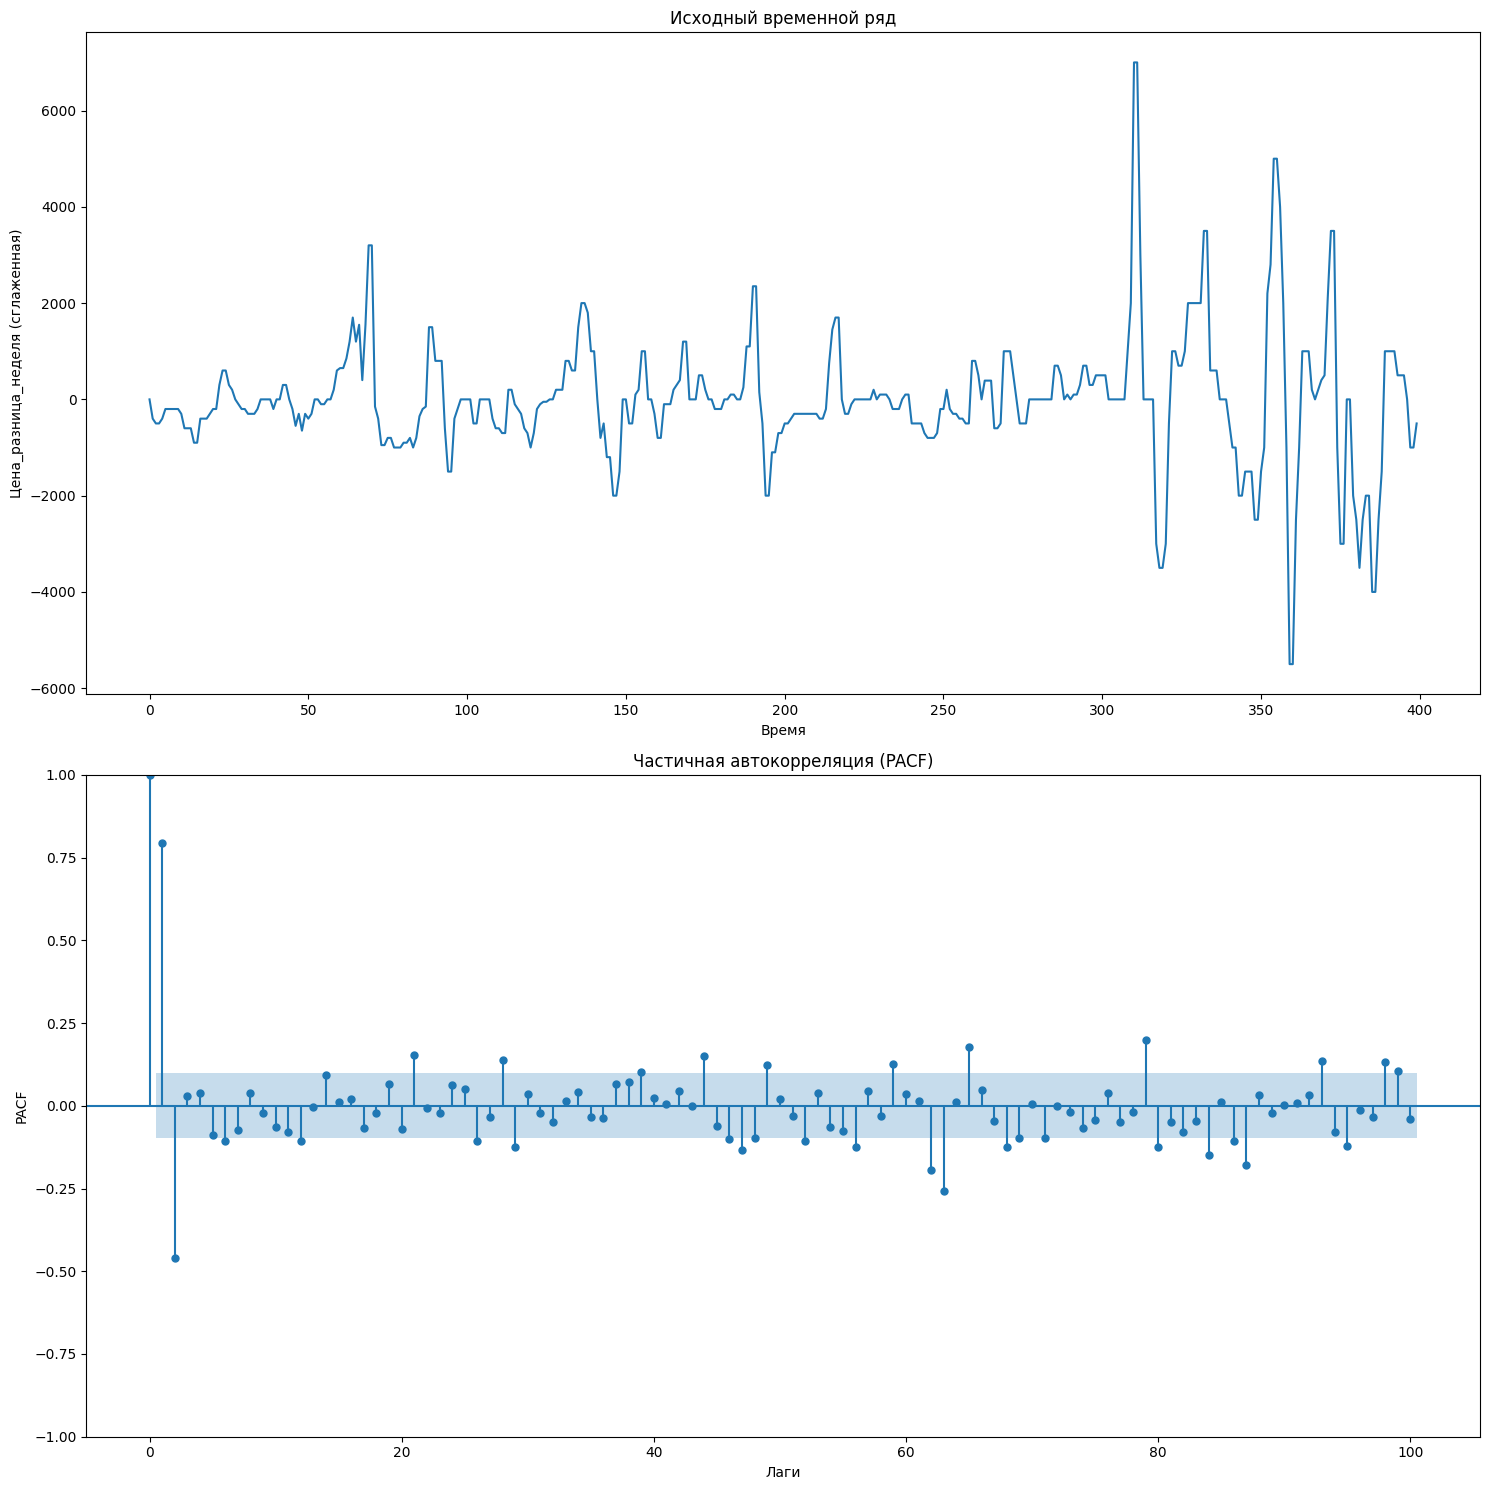

In [22]:
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt

# Создаем график с двумя подграфиками
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))

# Первый подграфик: исходный временной ряд
df_ts['Цена_разница_неделя (сглаженная)'].plot(ax=ax[0])
ax[0].set_title('Исходный временной ряд')
ax[0].set_xlabel('Время')
ax[0].set_ylabel('Цена_разница_неделя (сглаженная)')

# Второй подграфик: PACF (частичная автокорреляция)
plot_pacf(df_ts['Цена_разница_неделя (сглаженная)'], lags=100, ax=ax[1], method='ols')
ax[1].set_title('Частичная автокорреляция (PACF)')
ax[1].set_xlabel('Лаги')
ax[1].set_ylabel('PACF')

# Отображаем график
plt.tight_layout()
plt.show()

1. Верхний график (исходный временной ряд):

Хотя он выглядит волатильным, после проверки на стационарность можно сказать, что данные не содержат явного тренда.

Это значит, что применённые преобразования (медианное сглаживание и дифференцирование) сделали ряд пригодным для моделирования.

Колебания могут указывать на сезонность или авторегрессию.

___

2. Нижний график (PACF):

Высокое значение на первом лаге говорит о сильной краткосрочной зависимости в данных.

Дальнейшие значения колеблются вокруг 0, но есть несколько значимых пиков. Это может указывать на авторегрессионный процесс (AR), возможно, порядка 1 или 2.

Учитывая стационарность, можно попробовать модель AR(p), где p — это порядок, определяемый по PACF (например, если есть значимые пики на 1 и 2 лагах, можно взять AR(2)).


### Создание новых признаков

In [23]:
# Преобразуем столбец dt в datetime
df_ts['dt'] = pd.to_datetime(df_ts['dt'])

def create_features(df):
    # Работаем с копией, временно устанавливаем индекс
    temp_df = df.copy().set_index('dt').sort_index()

    # Удаляем конфликтующие столбцы из временного DataFrame
    cols_to_drop = ['Цена_разница_неделя', 'Цена_разница_неделя (сглаженная)']
    temp_df = temp_df.drop(columns=[col for col in cols_to_drop if col in temp_df.columns])

    # Лаговые фичи
    for lag in [2, 3, 4, 12, 24]:
        temp_df[f'lag_{lag}'] = temp_df['Цена на арматуру'].shift(lag)

    # Скользящие статистики
    for window in [4, 12, 24]:
        temp_df[f'rolling_mean_{window}'] = temp_df['Цена на арматуру'].rolling(window=window).mean()
        temp_df[f'rolling_std_{window}'] = temp_df['Цена на арматуру'].rolling(window=window).std()

    # Сезонные фичи
    temp_df['month'] = temp_df.index.month
    temp_df['week_of_year'] = temp_df.index.isocalendar().week

    # Экспоненциальное сглаживание
    for alpha in [0.1, 0.3, 0.5]:
        temp_df[f'ewm_{alpha}'] = temp_df['Цена на арматуру'].ewm(alpha=alpha).mean()

    # Удаляем исходный столбец цены
    temp_df = temp_df.drop(columns=['Цена на арматуру'])

    # Присоединяем фичи через join (более безопасно чем merge)
    result = df.set_index('dt').join(temp_df, how='left').reset_index()
    return result

df_with_features = create_features(df_ts.copy())

In [24]:
df_with_features.head()

,dt,Цена на арматуру,Цена_разница_неделя,Цена_разница_неделя (сглаженная),lag_2,lag_3,lag_4,lag_12,lag_24,rolling_mean_4,rolling_std_4,rolling_mean_12,rolling_std_12,rolling_mean_24,rolling_std_24,month,week_of_year,ewm_0.1,ewm_0.3,ewm_0.5
0,2015-01-05,32900,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2,32900.000000,32900.000000,32900.000000
1,2015-01-12,32500,-400.0,-400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3,32689.473684,32664.705882,32633.333333
2,2015-01-19,32000,-500.0,-500.0,32900.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,4,32435.055351,32361.187215,32271.428571
3,2015-01-26,30700,-1300.0,-500.0,32500.0,32900.0,NaN,NaN,NaN,32025.0,956.991815,NaN,NaN,NaN,NaN,1,5,31930.532131,31705.369128,31433.333333
4,2015-02-02,30300,-400.0,-400.0,32000.0,32500.0,32900.0,NaN,NaN,31375.0,1043.631480,NaN,NaN,NaN,NaN,2,6,31532.365510,31198.582813,30848.387097


In [25]:
df_with_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 20 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   dt                                400 non-null    datetime64[ns]
 1   Цена на арматуру                  400 non-null    int64         
 2   Цена_разница_неделя               400 non-null    float64       
 3   Цена_разница_неделя (сглаженная)  400 non-null    float64       
 4   lag_2                             398 non-null    float64       
 5   lag_3                             397 non-null    float64       
 6   lag_4                             396 non-null    float64       
 7   lag_12                            388 non-null    float64       
 8   lag_24                            376 non-null    float64       
 9   rolling_mean_4                    397 non-null    float64       
 10  rolling_std_4                     397 non-null    

In [26]:
from sklearn.impute import KNNImputer
import pandas as pd

# Выводим информацию о данных ДО заполнения пропусков
print("Информация о данных ДО заполнения пропусков:")
df_with_features.info()
print("\nКоличество пропусков по колонкам ДО заполнения:")
df_with_features.isnull().sum()

# Выбираем только числовые столбцы
numeric_cols = df_with_features.select_dtypes(include=['float64', 'int64']).columns
df_numeric = df_with_features[numeric_cols]

# Инициализируем KNNImputer
imputer = KNNImputer(n_neighbors=12)

# Заполняем пропуски
df_filled = pd.DataFrame(
    imputer.fit_transform(df_numeric),
    columns=df_numeric.columns,
    index=df_numeric.index
)

# Возвращаем нечисловые столбцы (если есть)
df_final = df_with_features.copy()
df_final[numeric_cols] = df_filled

# Выводим информацию о данных ПОСЛЕ заполнения пропусков
print("\nИнформация о данных ПОСЛЕ заполнения пропусков:")
df_final.info()
print("\nКоличество пропусков по колонкам ПОСЛЕ заполнения:")
df_final.isnull().sum()

# Дополнительно: выводим первые 5 строк для визуальной проверки
print("\nПервые 5 строк данных после заполнения:")
df_final.head()

Информация о данных ДО заполнения пропусков:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 20 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   dt                                400 non-null    datetime64[ns]
 1   Цена на арматуру                  400 non-null    int64         
 2   Цена_разница_неделя               400 non-null    float64       
 3   Цена_разница_неделя (сглаженная)  400 non-null    float64       
 4   lag_2                             398 non-null    float64       
 5   lag_3                             397 non-null    float64       
 6   lag_4                             396 non-null    float64       
 7   lag_12                            388 non-null    float64       
 8   lag_24                            376 non-null    float64       
 9   rolling_mean_4                    397 non-null    float64       
 10  rolli

,dt,Цена на арматуру,Цена_разница_неделя,Цена_разница_неделя (сглаженная),lag_2,lag_3,lag_4,lag_12,lag_24,rolling_mean_4,rolling_std_4,rolling_mean_12,rolling_std_12,rolling_mean_24,rolling_std_24,month,week_of_year,ewm_0.1,ewm_0.3,ewm_0.5
0,2015-01-05,32900.0,0.0,0.0,33045.000000,32904.166667,32854.166667,33041.666667,33833.333333,33007.708333,525.099803,33090.763889,1217.618330,32711.597222,1858.807236,1,2,32900.000000,32900.000000,32900.000000
1,2015-01-12,32500.0,-400.0,-400.0,32924.166667,32911.666667,33103.333333,33275.000000,32737.500000,32807.916667,599.625681,33181.041667,1355.622067,32729.027778,2109.134005,1,3,32689.473684,32664.705882,32633.333333
2,2015-01-19,32000.0,-500.0,-500.0,32900.000000,32849.166667,32703.333333,34100.000000,32166.666667,32638.125000,586.979880,33080.347222,1497.986517,32806.493056,2278.366349,1,4,32435.055351,32361.187215,32271.428571
3,2015-01-26,30700.0,-1300.0,-500.0,32500.000000,32900.000000,32945.000000,35454.166667,31566.666667,32025.000000,956.991815,33260.694444,2029.329075,33134.340278,3206.224010,1,5,31930.532131,31705.369128,31433.333333
4,2015-02-02,30300.0,-400.0,-400.0,32000.000000,32500.000000,32900.000000,35187.500000,31900.000000,31375.000000,1043.631480,32915.208333,1973.753657,33135.381944,2999.086842,2,6,31532.365510,31198.582813,30848.387097


In [27]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 20 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   dt                                400 non-null    datetime64[ns]
 1   Цена на арматуру                  400 non-null    float64       
 2   Цена_разница_неделя               400 non-null    float64       
 3   Цена_разница_неделя (сглаженная)  400 non-null    float64       
 4   lag_2                             400 non-null    float64       
 5   lag_3                             400 non-null    float64       
 6   lag_4                             400 non-null    float64       
 7   lag_12                            400 non-null    float64       
 8   lag_24                            400 non-null    float64       
 9   rolling_mean_4                    400 non-null    float64       
 10  rolling_std_4                     400 non-null    

# Модели

### Линейная регрессия


Проверка кросс-валидации на оптимизированной модели:
R² кросс-валидация: 0.77 (±0.12)

Результаты подбора Ridge регрессии для оптимизированных признаков:
Лучший alpha: 100
Лучший R²: 0.82
R² Ridge на тесте: 0.81

Проверка на утечку данных для оптимизированных признаков:
Ошибка: Обнаружена возможная утечка данных в лагах!
Лаги были пересчитаны корректно

Финальные метрики оптимизированной модели:
Средняя абсолютная ошибка (MAE): 3292.50
Корень среднеквадратичной ошибки (RMSE): 4463.99
Симметричная MAPE (SMAPE): 5.37%
Коэффициент детерминации (R²): 0.81


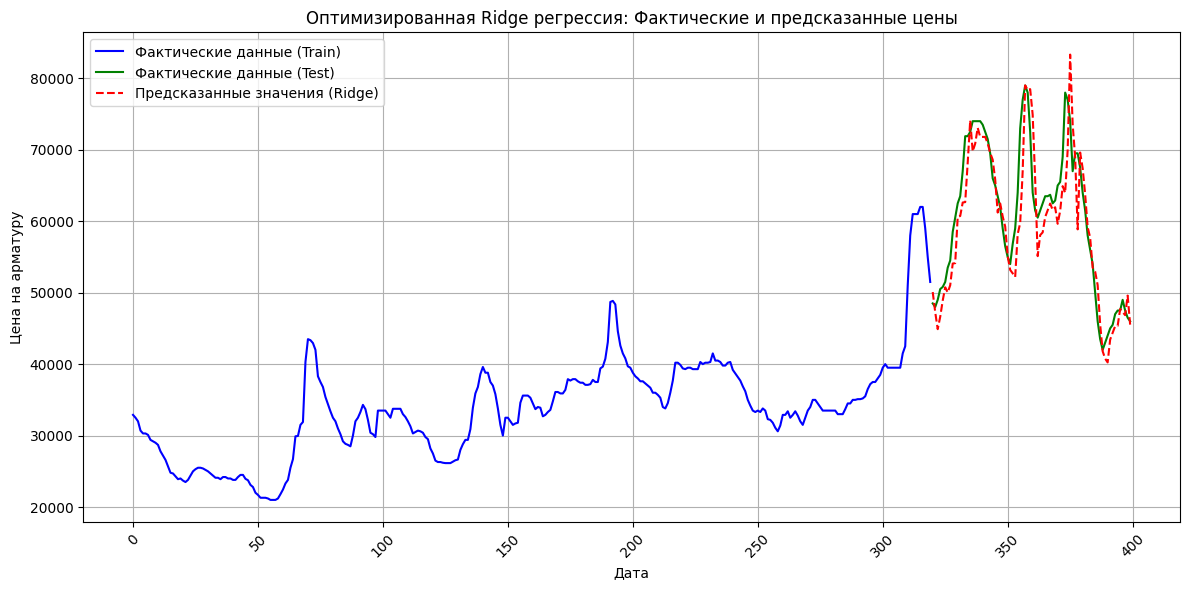


R² наивной модели (завтра=сегодня): 0.92


In [28]:
# Оптимальный набор признаков на основе анализа
best_features = ['lag_2', 'lag_3', 'month']

# Определение признаков (X) и целевой переменной (y)
X = df_final[best_features]
y = df_final["Цена на арматуру"]

# Разделение данных на обучающую и тестовую выборки
split_index = int(len(X) * 0.8)
X_train_lr, X_test_lr = X[:split_index], X[split_index:]
y_train_lr, y_test_lr = y[:split_index], y[split_index:]

# ==================== 1. Кросс-валидация временных рядов ====================
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

tscv = TimeSeriesSplit(n_splits=5)
print("\nПроверка кросс-валидации на оптимизированной модели:")
cv_scores = cross_val_score(LinearRegression(), X, y, cv=tscv, scoring='r2')
print(f"R² кросс-валидация: {cv_scores.mean():.2f} (±{cv_scores.std():.2f})")

# ==================== 2. Регуляризация модели (Ridge) ====================
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

# Подбор оптимального alpha для Ridge
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
ridge = Ridge()
grid_search = GridSearchCV(ridge, param_grid, cv=tscv, scoring='r2')
grid_search.fit(X_train_lr, y_train_lr)

print("\nРезультаты подбора Ridge регрессии для оптимизированных признаков:")
print(f"Лучший alpha: {grid_search.best_params_['alpha']}")
print(f"Лучший R²: {grid_search.best_score_:.2f}")

# Используем лучшую модель Ridge
best_ridge = grid_search.best_estimator_
y_pred_ridge = best_ridge.predict(X_test_lr)
r2_ridge = r2_score(y_test_lr, y_pred_ridge)
print(f"R² Ridge на тесте: {r2_ridge:.2f}")

# ==================== 3. Проверка на утечку данных ====================
print("\nПроверка на утечку данных для оптимизированных признаков:")
try:
    assert df_final['lag_2'].equals(df_final['Цена на арматуру'].shift(2))
    assert df_final['lag_3'].equals(df_final['Цена на арматуру'].shift(3))
    print("Все лаги корректны - утечки данных нет")
except AssertionError:
    print("Ошибка: Обнаружена возможная утечка данных в лагах!")
    # Пересчитываем лаги правильно
    df_final['lag_2'] = df_final['Цена на арматуру'].shift(2)
    df_final['lag_3'] = df_final['Цена на арматуру'].shift(3)
    print("Лаги были пересчитаны корректно")

# ==================== Оценка финальной модели ====================
# Используем Ridge с лучшим параметром
model_lr = Ridge(alpha=grid_search.best_params_['alpha'])
model_lr.fit(X_train_lr, y_train_lr)
y_pred_final = model_lr.predict(X_test_lr)

# Метрики
mae_lr = mean_absolute_error(y_test_lr, y_pred_final)
rmse_lr = np.sqrt(mean_squared_error(y_test_lr, y_pred_final))
smape_lr = np.mean(2 * np.abs(y_test_lr - y_pred_final) / (np.abs(y_test_lr) + np.abs(y_pred_final))) * 100
r2_lr = r2_score(y_test_lr, y_pred_final)

print("\nФинальные метрики оптимизированной модели:")
print(f"Средняя абсолютная ошибка (MAE): {mae_lr:.2f}")
print(f"Корень среднеквадратичной ошибки (RMSE): {rmse_lr:.2f}")
print(f"Симметричная MAPE (SMAPE): {smape_lr:.2f}%")
print(f"Коэффициент детерминации (R²): {r2_lr:.2f}")

# Визуализация
plt.figure(figsize=(12, 6))
dates = df_final.index
train_dates = dates[:split_index]
test_dates = dates[split_index:]

plt.plot(train_dates, y_train_lr, color="blue", label="Фактические данные (Train)")
plt.plot(test_dates, y_test_lr, color="green", label="Фактические данные (Test)")
plt.plot(test_dates, y_pred_final, color="red", linestyle="dashed", label="Предсказанные значения (Ridge)")

plt.xlabel("Дата")
plt.ylabel("Цена на арматуру")
plt.title("Оптимизированная Ridge регрессия: Фактические и предсказанные цены")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Сравнение с наивной моделью
naive_pred = y_test_lr.shift(1).dropna()
naive_r2 = r2_score(y_test_lr[1:], naive_pred)
print(f"\nR² наивной модели (завтра=сегодня): {naive_r2:.2f}")

### Arima ✅

In [29]:
# Разделим данные на тренировочные и тестовые выборки (80%/20%)
train_size_a = int(len(df_ts) * 0.8)
train_a, test_a = df_ts['Цена_разница_неделя (сглаженная)'][:train_size_a], df_ts['Цена_разница_неделя (сглаженная)'][train_size_a:]

# Применим auto_arima для подбора модели ARIMA
model = auto_arima(train_a, seasonal=False, stepwise=True, trace=True)

# Выводим информацию о лучшей модели
print(f"Лучшие параметры ARIMA: {model.order}")


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=4960.120, Time=0.97 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5314.108, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=5012.833, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=5087.915, Time=0.19 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=4962.189, Time=0.21 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=4965.332, Time=0.18 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=4959.610, Time=2.08 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=4967.031, Time=0.58 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=4961.644, Time=1.96 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=inf, Time=3.31 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=4960.097, Time=4.32 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=4960.760, Time=1.39 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=inf, Time=3.85 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=4961.691, Time=2.97 sec

Best model:  ARIMA(3,0,2)(0,0,0)[0]       

In [30]:
# Выбираем столбец с данными временного ряда
time_series_a = df_ts['Цена_разница_неделя (сглаженная)']
model = ARIMA(time_series_a, order= model.order )
fitted_model = model.fit()


MAE: 769.0646
RMSE: 1098.8027
SMAPE: 75.17%
R^2: 0.7440


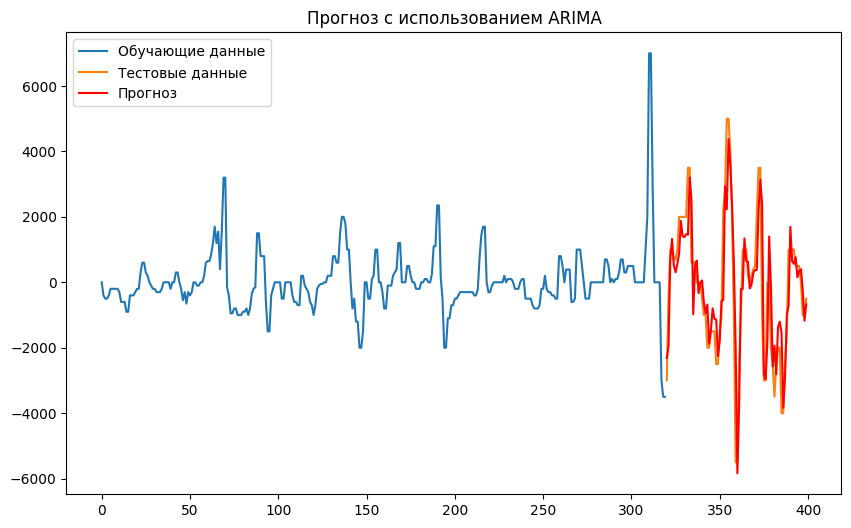

In [31]:
# Прогнозируем на тестовых данных
forecast = fitted_model.predict(start=len(train_a), end=len(train_a) + len(test_a) - 1)

from sklearn.metrics import r2_score  # Импортируем r2_score

# Средняя абсолютная ошибка (MAE)
mae_a = mean_absolute_error(test_a, forecast)
print(f"MAE: {mae_a:.4f}")

# Корень среднеквадратичной ошибки (RMSE)
rmse_a = np.sqrt(mean_squared_error(test_a, forecast))
print(f"RMSE: {rmse_a:.4f}")

# Симметричная MAPE (SMAPE)
smape_a = np.mean(2 * np.abs(forecast - test_a) / (np.abs(test_a) + np.abs(forecast))) * 100
print(f"SMAPE: {smape_a:.2f}%")

# Коэффициент детерминации (R^2)
r2_a = r2_score(test_a, forecast)
print(f"R^2: {r2_a:.4f}")

# Визуализируем результат
plt.figure(figsize=(10, 6))
plt.plot(train_a, label='Обучающие данные')
plt.plot(test_a, label='Тестовые данные')
plt.plot(forecast, label='Прогноз', color='red')
plt.legend()
plt.title('Прогноз с использованием ARIMA')
plt.show()

### XGboost

Начинаем быстрый подбор параметров...
Fitting 3 folds for each of 36 candidates, totalling 108 fits

Лучшие параметры: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}

Результаты после GridSearch:
MAE: 10428.88
RMSE: 12651.53
SMAPE: 17.51%
R^2: -0.5274


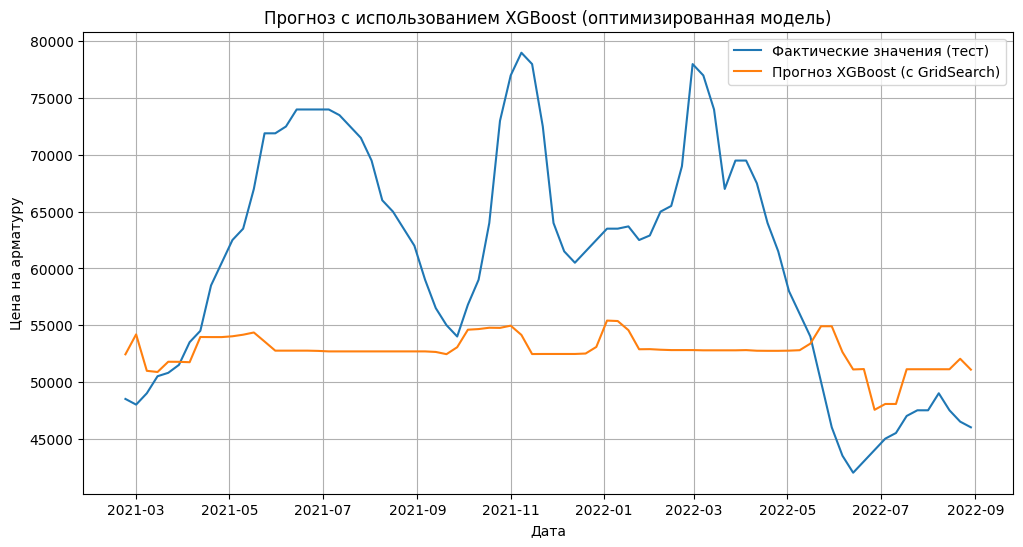

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# Преобразуем колонку 'dt' в datetime, но не делаем её индексом
df_final['dt'] = pd.to_datetime(df_final['dt'])



# Определяем фичи и целевую переменную
target_col = 'Цена на арматуру'
feature_cols = [
    'lag_2', 'lag_3', 'lag_4', 'lag_12', 'lag_24',
    'rolling_mean_12', 'rolling_mean_24',
    'month', 'week_of_year', 'ewm_0.3'
]

# Масштабирование данных
scaler_features = MinMaxScaler()
scaler_price = MinMaxScaler()

df_final[feature_cols] = scaler_features.fit_transform(df_final[feature_cols])
df_final[[target_col]] = scaler_price.fit_transform(df_final[[target_col]])

# Разделение данных на train/test
train_size = int(len(df_final) * 0.8)
train, test = df_final.iloc[:train_size], df_final.iloc[train_size:]

X_train, y_train = train[feature_cols], train[target_col]
X_test, y_test = test[feature_cols], test[target_col]

# Параметры для GridSearch
# Упрощенные параметры для GridSearch
param_grid = {
    'n_estimators': [100, 200, 300],       # Уменьшили количество вариантов
    'learning_rate': [0.05, 0.1],     # Более агрессивные значения
    'max_depth': [3, 5, 7],              # Меньше вариантов глубины
    'subsample': [0.8, 0.9],          # Упростили
    'colsample_bytree': [0.8]         # Одно значение вместо нескольких
    # Убрали gamma для упрощения
}

# Создание модели для GridSearch с более быстрыми параметрами
xgb = XGBRegressor(
    random_state=42,
    tree_method='hist',  # Более быстрый метод
    early_stopping_rounds=10  # Ранняя остановка
)

# Настройка GridSearchCV с упрощениями
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=3,  # Меньше фолдов для скорости
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# Запуск GridSearch с ранней остановкой
print("Начинаем быстрый подбор параметров...")
grid_search.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],  # Для ранней остановки
    verbose=0  # Уменьшаем вывод
)

# Лучшие параметры
best_params = grid_search.best_params_
print("\nЛучшие параметры:", best_params)

# Лучшая модель
best_xgb = grid_search.best_estimator_

# Предсказание
y_pred = best_xgb.predict(X_test)

# Обратное масштабирование
y_test_inv = scaler_price.inverse_transform(y_test.values.reshape(-1, 1))
y_pred_inv = scaler_price.inverse_transform(y_pred.reshape(-1, 1))

# Вычисление метрик
mae_xgb = mean_absolute_error(y_test_inv, y_pred_inv)
rmse_xgb = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
smape_xgb = np.mean(2 * np.abs(y_test_inv - y_pred_inv) / (np.abs(y_test_inv) + np.abs(y_pred_inv))) * 100
r2_xgb = r2_score(y_test_inv, y_pred_inv)

print("\nРезультаты после GridSearch:")
print(f"MAE: {mae_xgb:.2f}")
print(f"RMSE: {rmse_xgb:.2f}")
print(f"SMAPE: {smape_xgb:.2f}%")
print(f"R^2: {r2_xgb:.4f}")

# Визуализация
test_dates = df_final.iloc[train_size:]['dt'].values

plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test_inv, label="Фактические значения (тест)")
plt.plot(test_dates, y_pred_inv, label="Прогноз XGBoost (с GridSearch)")
plt.xlabel("Дата")
plt.ylabel("Цена на арматуру")
plt.title("Прогноз с использованием XGBoost (оптимизированная модель)")
plt.legend()
plt.grid(True)
plt.show()

### GRU

Epoch 1/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - loss: 0.2729 - val_loss: 0.2062
Epoch 2/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.1483 - val_loss: 0.1387
Epoch 3/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0867 - val_loss: 0.0916
Epoch 4/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0569 - val_loss: 0.0710
Epoch 5/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0407 - val_loss: 0.0721
Epoch 6/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0307 - val_loss: 0.0537
Epoch 7/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0242 - val_loss: 0.0486
Epoch 8/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0209 - val_loss: 0.0438
Epoch 9/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0155 - val_loss: 0.0364
Epoch 10/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0142 - val_loss: 0.0398
Epoch 11/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0114 - val_loss: 0.0597
Epoch 12/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/ste

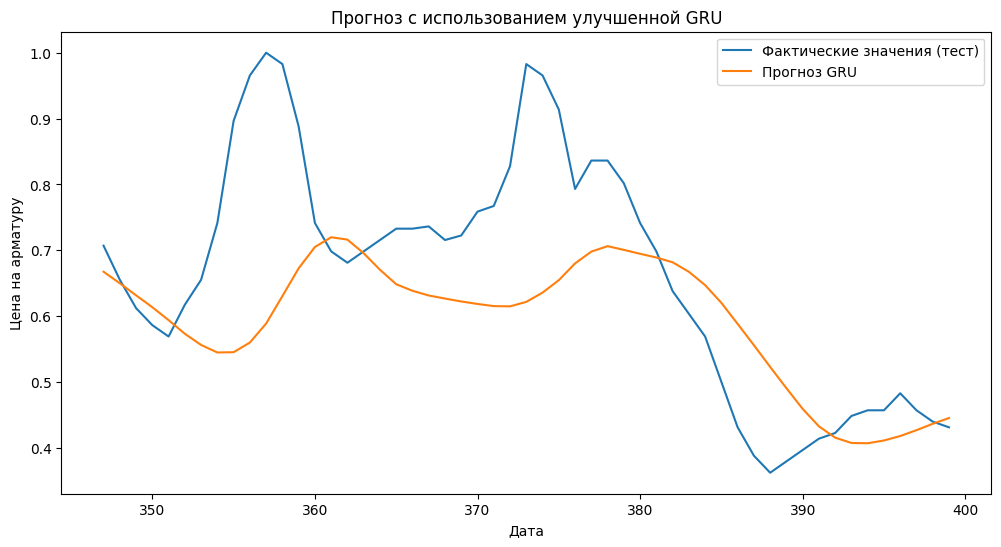

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# Определяем, какие фичи будем использовать
target_col = "Цена на арматуру"
feature_cols = [
    "lag_2", "lag_3", "lag_4", "lag_12", "lag_24",
    "rolling_mean_12", "rolling_mean_24",
    "month", "week_of_year", "ewm_0.3"
]

# Удаляем NaN перед масштабированием
df_final = df_final.dropna(subset=feature_cols + [target_col])

# Масштабирование данных
scaler_features = MinMaxScaler()
scaler_price = MinMaxScaler()

df_final[feature_cols] = scaler_features.fit_transform(df_final[feature_cols])
df_final[[target_col]] = scaler_price.fit_transform(df_final[[target_col]])

# Разделение данных
train_size = int(len(df_final) * 0.7)
val_size = int(len(df_final) * 0.15)

train = df_final.iloc[:train_size]
val = df_final.iloc[train_size:train_size + val_size]
test = df_final.iloc[train_size + val_size:]

# Функция создания последовательностей
def create_sequences(data, target_col, seq_length=6):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i+seq_length][feature_cols].values)
        y.append(data.iloc[i+seq_length][target_col])
    return np.array(X), np.array(y)

seq_length = 8 # Уменьшили длину последовательности

X_train, y_train = create_sequences(train, target_col, seq_length)
X_val, y_val = create_sequences(val, target_col, seq_length)
X_test, y_test = create_sequences(test, target_col, seq_length)

# Проверка NaN
assert not np.isnan(X_train).any(), "NaN в X_train"
assert not np.isnan(y_train).any(), "NaN в y_train"
assert not np.isnan(X_val).any(), "NaN в X_val"
assert not np.isnan(y_val).any(), "NaN в y_val"
assert not np.isnan(X_test).any(), "NaN в X_test"
assert not np.isnan(y_test).any(), "NaN в y_test"

# Улучшенная модель GRU
model_gru = Sequential([
    Bidirectional(GRU(128, return_sequences=True, kernel_regularizer=l2(0.001), input_shape=(seq_length, X_train.shape[2]))),
    Dropout(0.3),
    GRU(64, kernel_regularizer=l2(0.001)),
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(1)
])

model_gru.compile(optimizer='adam', loss='mse')

# Обучение модели
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

history = model_gru.fit(
    X_train, y_train, epochs=200, batch_size=8,
    validation_data=(X_val, y_val), verbose=1, callbacks=[early_stop]
)

# Предсказание
y_pred = model_gru.predict(X_test)

# Проверяем NaN перед обратным масштабированием
assert not np.isnan(y_pred).any(), "NaN в y_pred перед inverse_transform"

# Обратное масштабирование
y_test_inv = scaler_price.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler_price.inverse_transform(y_pred.reshape(-1, 1))

# Проверяем NaN после обратного масштабирования
assert not np.isnan(y_test_inv).any(), "NaN в y_test_inv после inverse_transform"
assert not np.isnan(y_pred_inv).any(), "NaN в y_pred_inv после inverse_transform"

# Вычисление метрик
mae_g = mean_absolute_error(y_test_inv, y_pred_inv)
rmse_g = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
smape_g = np.mean(2 * np.abs(y_test_inv - y_pred_inv) / (np.abs(y_test_inv) + np.abs(y_pred_inv) + 1e-6)) * 100
r2_g = r2_score(y_test_inv, y_pred_inv)

print(f"MAE: {mae_g:.2f}")
print(f"RMSE: {rmse_g:.2f}")
print(f"SMAPE: {smape_g:.2f}%")
print(f"R^2: {r2_g:.4f}")

# Визуализация результатов
plt.figure(figsize=(12, 6))
plt.plot(df_final.index[train_size + val_size + seq_length:], y_test_inv, label="Фактические значения (тест)")
plt.plot(df_final.index[train_size + val_size + seq_length:], y_pred_inv, label="Прогноз GRU")
plt.xlabel("Дата")
plt.ylabel("Цена на арматуру")
plt.title("Прогноз с использованием улучшенной GRU")
plt.legend()
plt.show()

## Лучшая модель

## Лучшая модель


Лучшая модель (по комплексной оценке): Linear Regression
Linear Regression: 0.8167
ARIMA: 0.7348
XGBoost: -0.0420
GRU: 0.7405


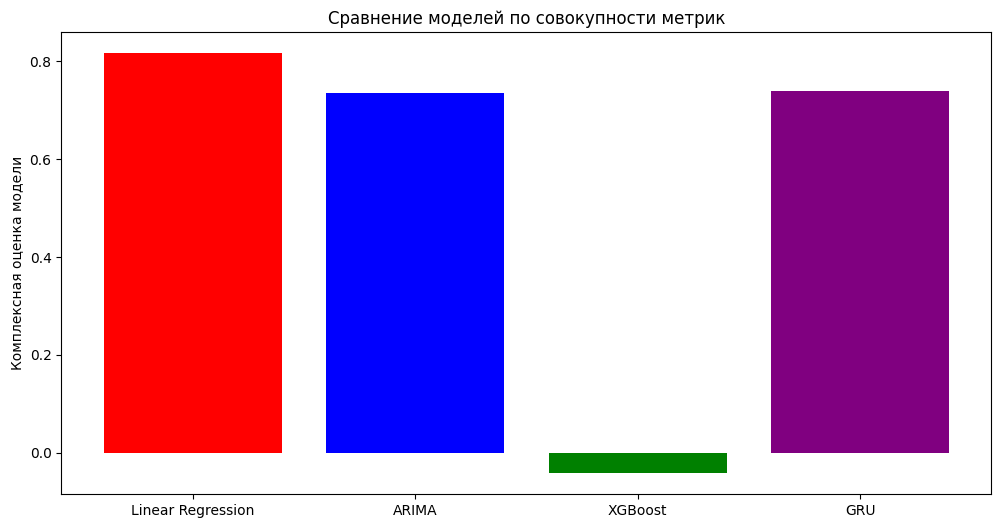

Модель Linear Regression: <class 'sklearn.linear_model._ridge.Ridge'>
Модель ARIMA: <class 'statsmodels.tsa.arima.model.ARIMAResultsWrapper'>
Модель XGBoost: <class 'xgboost.sklearn.XGBRegressor'>
Модель GRU: <class 'keras.src.models.sequential.Sequential'>
Лучшая модель (Linear Regression) сохранена в формате joblib (.joblib)


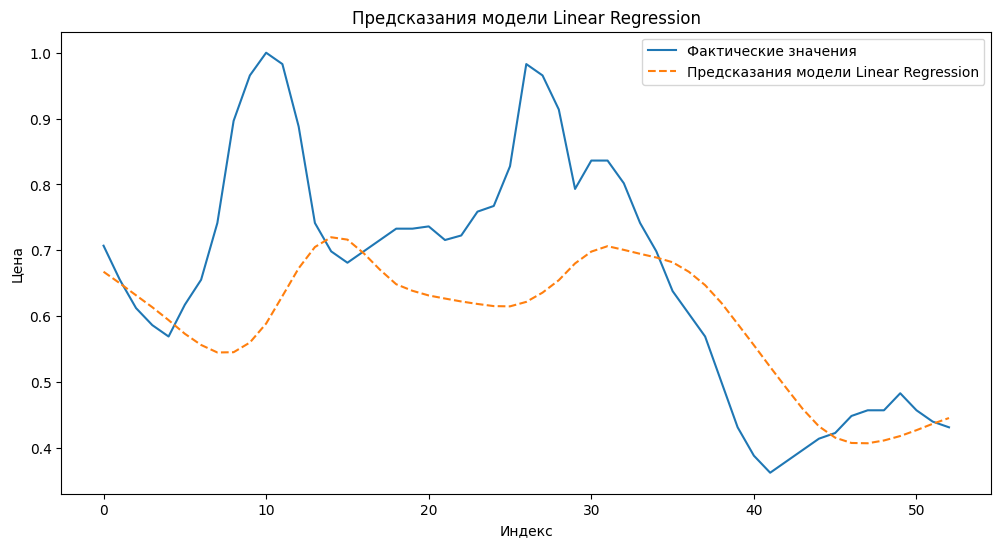

In [34]:
import matplotlib.pyplot as plt
import joblib
import pickle
from tensorflow import keras

# Словарь для хранения метрик всех моделей
model_metrics = {
    "Linear Regression": {
        "MAE": mae_lr,
        "RMSE": rmse_lr,
        "R^2": r2_lr,
        "SMAPE": smape_lr,
    },
    "ARIMA": {
        "MAE": mae_a,
        "RMSE": rmse_a,
        "R^2": r2_a,
        "SMAPE": smape_a,
    },
    "XGBoost": {
        "MAE": mae_xgb,
        "RMSE": rmse_xgb,
        "R^2": r2_xgb,
        "SMAPE": smape_xgb,
    },
    "GRU": {
        "MAE": mae_g,
        "RMSE": rmse_g,
        "R^2": r2_g,
        "SMAPE": smape_g,
    }
}

# Определяем максимальные значения для нормализации
max_mae = max(m["MAE"] for m in model_metrics.values())
max_rmse = max(m["RMSE"] for m in model_metrics.values())
max_r2 = max(m["R^2"] for m in model_metrics.values())
max_smape = max(m["SMAPE"] for m in model_metrics.values())

# Веса метрик (можно настроить по приоритету)
alpha, beta, gamma, delta = 0.2, 0.3, 0.3, 0.2  # MAE, RMSE, R², SMAPE

# Вычисление общего рейтинга для каждой модели
model_scores = {
    model: (
        alpha * (1 - metrics["MAE"] / max_mae) +
        beta * (1 - metrics["RMSE"] / max_rmse) +
        gamma * (metrics["R^2"] / max_r2) +
        delta * (1 - metrics["SMAPE"] / max_smape)
    )
    for model, metrics in model_metrics.items()
}

# Определяем лучшую модель
best_model = max(model_scores, key=model_scores.get)
print("\nЛучшая модель (по комплексной оценке):", best_model)

# Вывод результатов
for model, score in model_scores.items():
    print(f"{model}: {score:.4f}")

# Визуализация сравнения моделей
plt.figure(figsize=(12, 6))
plt.bar(model_scores.keys(), model_scores.values(), color=["red", "blue", "green", "purple"])
plt.ylabel("Комплексная оценка модели")
plt.title("Сравнение моделей по совокупности метрик")
plt.show()

# Определяем словарь с моделями
model_dict = {
    "Linear Regression": model_lr if "model_lr" in globals() else None,
    "ARIMA": fitted_model if "fitted_model" in globals() else None,
    "XGBoost": best_xgb if "best_xgb" in globals() else None,
    "GRU": model_gru if "model_gru" in globals() else None
}

# Вывод типов всех моделей для отладки
for name, model in model_dict.items():
    print(f"Модель {name}: {type(model)}")

# Проверяем, есть ли модель в словаре
best_trained_model = model_dict.get(best_model)

if best_trained_model is None:
    raise ValueError(f"Ошибка: модель '{best_model}' не найдена или имеет некорректный тип")

# Сохранение модели в зависимости от типа
if best_model == "GRU":
    # Сохраняем GRU модель
    best_trained_model.save('best_gru_model.keras')  # или .h5 для старых версий Keras
    print("Лучшая модель (GRU) сохранена в формате Keras (.keras)")
elif best_model == "ARIMA":
    # Сохраняем ARIMA модель
    with open('best_arima_model.pkl', 'wb') as f:
        pickle.dump(best_trained_model, f)
    print("Лучшая модель (ARIMA) сохранена в формате pickle (.pkl)")
elif best_model == "XGBoost":
    # Сохраняем XGBoost модель
    joblib.dump(best_trained_model, 'best_xgboost_model.joblib')
    print("Лучшая модель (XGBoost) сохранена в формате joblib (.joblib)")
else:  # Linear Regression и другие sklearn-модели
    # Сохраняем sklearn модели
    joblib.dump(best_trained_model, 'best_sklearn_model.joblib')
    print(f"Лучшая модель ({best_model}) сохранена в формате joblib (.joblib)")

# Визуализация предсказаний (убедитесь, что y_pred определен для лучшей модели)
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Фактические значения")
plt.plot(y_pred, label=f"Предсказания модели {best_model}", linestyle="dashed")
plt.xlabel("Индекс")
plt.ylabel("Цена")
plt.title(f"Предсказания модели {best_model}")
plt.legend()
plt.show()

In [37]:
# Устанавливаем библиотеки
!pip install gradio joblib pandas openpyxl xgboost tensorflow statsmodels matplotlib

# Импортируем нужные модули
import pandas as pd
import joblib
import gradio as gr
import io
import matplotlib.pyplot as plt

# === ЗАГРУЗКА МОДЕЛИ ===
try:
    best_model = joblib.load("best_sklearn_model.joblib")  # Убедитесь, что этот файл загружен в Colab!
    print("Модель успешно загружена!")
except FileNotFoundError:
    raise FileNotFoundError("Ошибка: Загрузите файл best_sklearn_model.joblib в Colab перед запуском!")

# === ФУНКЦИЯ ДЛЯ ОБРАБОТКИ ДАННЫХ ===
def predict_armatura(data):
    try:
        df = pd.read_csv(io.StringIO(data))  # Читаем данные из загруженного CSV
    except Exception:
        return "Ошибка: Неверный формат файла! Загрузите корректный CSV."

    if "Цена на арматуру" not in df.columns:
        return "Ошибка: Файл должен содержать колонку 'Цена на арматуру'"

    # Делаем предсказание
    df["N_недель"] = best_model.predict(df[["Цена на арматуру"]])
    df["N_недель"] = df["N_недель"].round().clip(1, 6)  # Ограничиваем от 1 до 6 недель

    # Создаем график
    plt.figure(figsize=(10, 5))
    plt.plot(df["Цена на арматуру"], df["N_недель"], marker="o", linestyle="-", color="b", label="Прогноз N недель")
    plt.xlabel("Цена на арматуру")
    plt.ylabel("Кол-во недель")
    plt.title("Прогноз закупки арматуры")
    plt.legend()
    plt.grid(True)

    # Сохраняем график в объект BytesIO
    graph_output = io.BytesIO()
    plt.savefig(graph_output, format="png")
    graph_output.seek(0)

    return df, graph_output  # Возвращаем таблицу и график

# === СОЗДАЕМ ИНТЕРФЕЙС GRADIO ===
iface = gr.Interface(
    fn=predict_armatura,
    inputs=gr.File(label="Загрузите CSV-файл"),
    outputs=[gr.Dataframe(label="Результаты предсказания"), gr.Image(label="График предсказания")],
    title="Прогноз закупки арматуры",
    description="Загрузите CSV-файл с колонкой 'Цена на арматуру', и получите предсказания."
)

# === ЗАПУСК ПРИЛОЖЕНИЯ ===
iface.launch(share=True)  # Запускаем Gradio

Модель успешно загружена!
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://10f50919fef17512a5.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [36]:
import numpy as np
import pandas as pd
import requests
import os
import matplotlib.pyplot as plt
from io import BytesIO
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam
from joblib import dump, load

# === 1. Загрузка данных ===
def load_data(url):
    response = requests.get(url)
    return pd.read_excel(BytesIO(response.content), engine='openpyxl')

train_url = df_final
test_url = "https://github.com/samoletpanfilov/reinforcement_task/raw/refs/heads/master/data/test.xlsx"


df_test = load_data(test_url)


# === 2. Функция создания временных окон ===
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# === 3. Масштабирование данных ===
scaler_X_path = "scaler_X.joblib"
scaler_y_path = "scaler_y.joblib"

if os.path.exists(scaler_X_path) and os.path.exists(scaler_y_path):
    scaler_X = load(scaler_X_path)
    scaler_y = load(scaler_y_path)
    print("✅ Масштабаторы загружены из файлов")
else:
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    scaler_X.fit(df_train[['Цена на арматуру']])
    scaler_y.fit(df_train[['Цена на арматуру']])
    dump(scaler_X, scaler_X_path)
    dump(scaler_y, scaler_y_path)
    print("⚠ Масштабаторы не найдены, созданы новые")

data_train_scaled = scaler_X.transform(df_train['lag_2', 'lag_3', 'month'])
data_test_scaled = scaler_X.transform(df_test['lag_2', 'lag_3', 'month'])

# === 4. Формирование последовательностей ===
seq_length = 10

X_train, y_train = create_sequences(data_train_scaled, seq_length)
X_test, y_test = create_sequences(data_test_scaled, seq_length)

X_train = X_train.reshape(X_train.shape[0], seq_length, 1)
X_test = X_test.reshape(X_test.shape[0], seq_length, 1)

# === 5. Загрузка или создание модели ===
model_path = "best_gru_model.keras"

if os.path.exists(model_path):
    model = load_model(model_path)
    print("✅ Модель загружена из файла best_gru_model.keras")
else:
    print("⚠ Модель не найдена, создаем новую!")
    model = Sequential([
        GRU(50, activation='relu', input_shape=(seq_length, 1)),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    model.save(model_path)

model.summary()

# === 6. Обучение модели (если нужно) ===
train_model = False  # Установите True, если хотите переобучить модель

if train_model:
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)
    model.save(model_path)

# === 7. Прогнозирование на тестовых данных ===
y_pred = model.predict(X_test)
y_pred_inv = scaler_y.inverse_transform(y_pred)
y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# === 8. Визуализация результатов ===
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Фактические значения', marker='o')
plt.plot(y_pred_inv, label='Предсказанные значения', linestyle='dashed', marker='x', color='red')
plt.legend()
plt.title('Фактические vs Предсказанные цены')
plt.xlabel('Наблюдения')
plt.ylabel('Цена на арматуру')
plt.grid(True)
plt.show()

# === 9. Прогнозирование на N недель вперед ===
def predict_future(model, data, window_size, future_steps):
    predictions = []
    current_batch = data[-window_size:].reshape(1, window_size, 1)

    for _ in range(future_steps):
        pred = model.predict(current_batch, verbose=0)[0][0]
        pred_inv = scaler_y.inverse_transform([[pred]])[0][0]
        predictions.append(pred_inv)

        current_batch = np.append(current_batch[:, 1:, :], [[pred]], axis=1)

    return np.array(predictions)

future_steps = 6  # Сколько недель предсказывать
future_predictions = predict_future(model, data_test_scaled, seq_length, future_steps)

# === 10. Визуализация прогноза ===
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Фактические значения', marker='o')
plt.plot(range(len(y_test_inv), len(y_test_inv) + future_steps), future_predictions, label='Прогноз', linestyle='dashed', marker='x', color='green')
plt.legend()
plt.title(f'Прогноз на {future_steps} недель вперед')
plt.xlabel('Наблюдения')
plt.ylabel('Цена на арматуру')
plt.grid(True)
plt.show()

# === 11. Сохранение результатов ===
results = pd.DataFrame({
    'Дата': df_test["dt"].iloc[seq_length:seq_length + len(y_pred_inv)].values,
    'Фактическая цена': y_test_inv.flatten(),
    'Предсказанная цена': y_pred_inv.flatten()
})

results.to_csv("predictions.csv", index=False)
print("✅ Результаты сохранены в predictions.csv")

✅ Масштабаторы загружены из файлов


NameError: name 'df_train' is not defined